In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
from scipy.stats import ttest_1samp, trim_mean
sns.set(font_scale=2, style='ticks')
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Task files

## Task structure
### rawdata
* stimParam1 : velocity
* stimParam2 : gain
* stimParam3 : task period -- 1, swim-only; 2, visual-only
* stimParam4 : 1, CL; 2, OL, swim-only; 3, replay, visual-only; 0, visual-only, no replay
* stimParam5 : epoch index

## Behavioral data

In [2]:
vol_file = '../Analysis/depreciated/analysis_sections_sovo.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()

['05092019', 'Fish3-1-swimonly_visualonly']
['05092019', 'Fish3-2-swimonly_visualonly']
['05092019', 'Fish7-1-swimonly_visualonly']
['05092019', 'Fish7-2-swimonly_visualonly']
['05152019', 'Fish3-1-swimonly_visualonly']
['05152019', 'Fish4-1-swimonly_visualonly']
['05162019', 'Fish1-plane#2-before-swimonly_visualonly']
['05162019', 'Fish3-plane#1-before-swimonly_visualonly']
['05222019', 'Fish3-Plane#2-before-swimonly_visualonly']
['05232019', 'Fish2-Plane#2-before-swimonly_visualonly']
['05232019', 'Fish4-Plane#1-before-swimonly_visualonly']


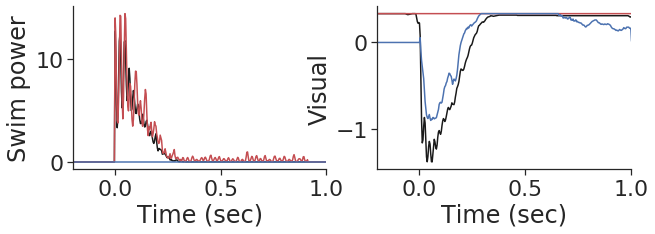

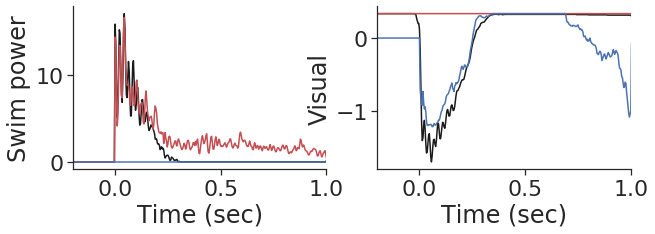

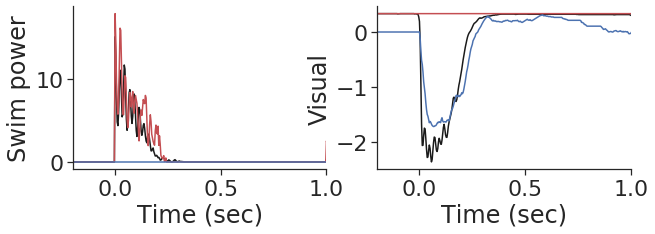

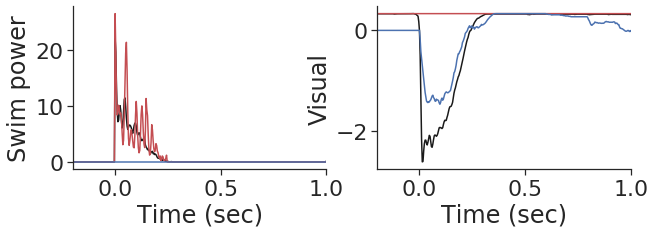

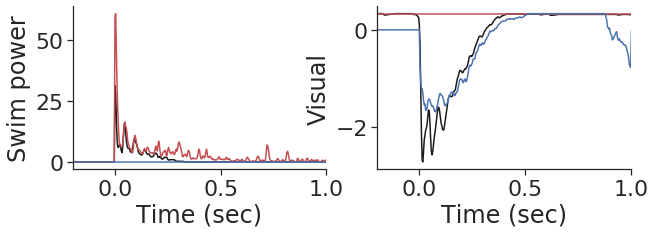

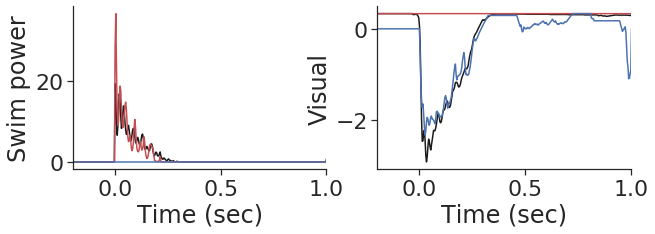

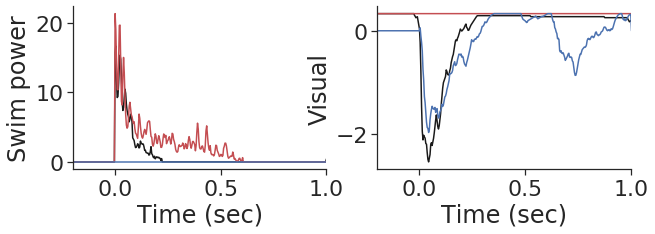

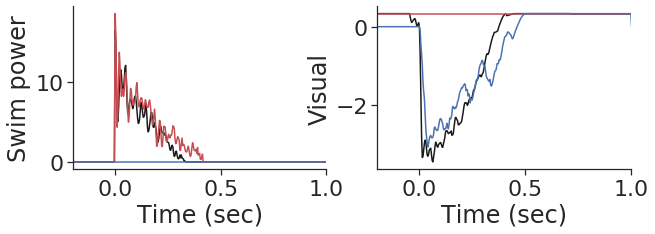

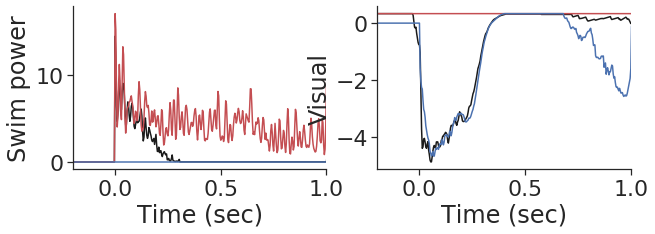

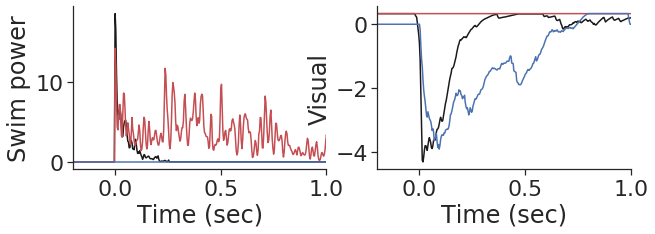

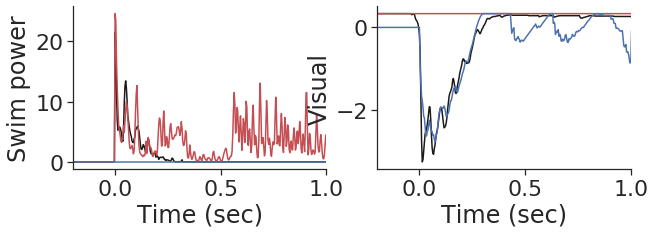

In [14]:
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']
swim_power_thres = 10
t_swim_CL = t_pre + 100
t_swim_OL = t_pre + 200

for ind, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
    if not os.path.exists(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz'):
        continue
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['swim_task_index'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)
    
    task_period = _['swim_task_index'].astype('int')            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    trial_valid = _['trial_valid']
    
    trial_pre = (p_swim[:, :t_pre]>0).sum(axis=-1)==0
    trial_valid_CL = (p_swim[:, t_swim_CL:t_swim_CL+150]>0).sum(axis=-1)==0
    trial_valid_CL = trial_valid_CL & trial_pre
    trial_valid_OL = ((visu.max(axis=-1, keepdims=True)-visu)[:, :-50]>0).sum(axis=-1)==0
    trial_valid_OL = trial_valid_OL & trial_pre
    # trial_valid_OL = trial_valid_OL & ((p_swim[:, t_swim_OL:t_pre+300]>1).sum(axis=-1)==0)
    # trial_valid_OL = trial_valid_OL & ((p_swim[:, t_swim_OL:t_swim_OL+150]>0).sum(axis=-1)==0)
    trial_valid_VL = (p_swim[:, t_pre:t_pre+300]>0).sum(axis=-1)==0

    if np.percentile(p_swim[(task_period==1) & trial_valid].mean(axis=0), 95)>swim_power_thres:
        continue
    
    if np.percentile(p_swim[(task_period==2) & trial_valid].mean(axis=0), 95)>swim_power_thres:
        continue
        
    if ((task_period==2) & trial_valid & trial_valid_OL).sum()<5:
        continue

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.flatten()
    
    for n in range(3):
        if n==0:
            trial_valid_ = trial_valid & trial_valid_CL
        if n==1:
            trial_valid_ = trial_valid & trial_valid_OL
        if n==2:
            trial_valid_ = trial_valid & trial_valid_VL
        ax[0].plot(t_label, p_swim[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        ax[1].plot(t_label, visu[(task_period==n+1) & trial_valid_].mean(axis=0), c_list[n])
        
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('Swim power')
    ax[0].set_xlim([-0.2, 1.0])
    ax[1].set_xlabel('Time (sec)')
    ax[1].set_ylabel('Visual')
    ax[1].set_xlim([-0.2, 1.0])
    sns.despine()
    plt.savefig(f'../Plots/sovo/swim_visual_{folder}_{fish}.pdf')
    print([folder, fish])

## Subthreshold activity

### Single cells

In [15]:
k_spk = gaussKernel(sigma=3)
k_sub = gaussKernel(sigma=11)

In [16]:
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
swim_power_thres = 10
t_swim_CL = t_pre + 100
t_swim_OL = t_pre + 200
t_label = np.arange(-t_pre, t_post)/300
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']
sub_ave = []
spk_ave = []
is_plot = False
fish_id = []

for ind, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
    if not os.path.exists(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz'):
        continue    
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    task_period = _['swim_task_index'].astype('int')            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    trial_valid = _['trial_valid']
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    task_period = _['swim_task_index'].astype('int')
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2 + l_swim**2)
    
    trial_pre = (p_swim[:, :t_pre]>0).sum(axis=-1)==0
    trial_valid_CL = (p_swim[:, t_swim_CL:t_swim_CL+150]>0).sum(axis=-1)==0
    trial_valid_CL = trial_valid_CL & trial_pre
    trial_valid_OL = ((visu.max(axis=-1, keepdims=True)-visu)[:, :-50]>0).sum(axis=-1)==0
    trial_valid_OL = trial_valid_OL & trial_pre & ((p_swim[:, t_swim_OL:t_pre+300]>1).sum(axis=-1)==0)
    # trial_valid_OL = trial_valid_OL & ((p_swim[:, t_swim_OL:t_swim_OL+150]>0).sum(axis=-1)==0)
    trial_valid_VL = (p_swim[:, t_pre:t_pre+300]>0).sum(axis=-1)==0

    if np.percentile(p_swim[(task_period==1) & trial_valid].mean(axis=0), 95)>swim_power_thres:
        continue
    
    if np.percentile(p_swim[(task_period==2) & trial_valid].mean(axis=0), 95)>swim_power_thres:
        continue
        
    if ((task_period==2) & trial_valid & trial_valid_OL).sum()<5:
        continue
    
    for n_cell in range(sub_swim.shape[0]):
        sub_list = sub_swim[n_cell]
        tmp = []
        for n_spk in sub_list:
            tmp.append(smooth(n_spk, k_sub))
        sub_list = np.array(tmp)
        sub_list = sub_list - sub_list[:, (t_pre-60):t_pre].mean(axis=-1, keepdims=True)
        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_spk))
        spk_list = np.array(tmp)
        fish_id.append(folder+fish[:5])
        
        if is_plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 3))
            ax = ax.flatten()
            
        tmp1 = []
        tmp2 = []
        for n in range(3):
            if n==0:
                trial_valid_ = trial_valid & trial_valid_CL
            if n==1:
                trial_valid_ = trial_valid & trial_valid_OL  #& trial_valid_CL
            if n==2:
                trial_valid_ = trial_valid & trial_valid_VL
            ave_ = sub_list[(task_period==n+1) & trial_valid_, :]*100
            mean_ = np.median(ave_, axis=0)
            std_ = sem(ave_, axis=0, nan_policy='omit')
            if is_plot:
                ax[0].plot(t_label, mean_, f'-{c_list[n]}', lw=2)
                ax[0].plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
                ax[0].plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
                ax[0].set_xlim([-t_pre/300, t_post/300])
                ax[0].set_xlabel('Time (sec)')
                ax[0].set_ylabel('dF/F')
                sns.despine()
            tmp1.append(mean_)
            
            ave_ = spk_list[(task_period==n+1) & trial_valid_, :]*300
            mean_ = np.mean(ave_, axis=0)
            std_ = sem(ave_, axis=0, nan_policy='omit')
            if is_plot:
                ax[1].plot(t_label, mean_, f'-{c_list[n]}', lw=2, label=labels[n])
                ax[1].plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
                ax[1].plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
                ax[1].set_xlim([-t_pre/300, t_post/300])
                ax[1].set_xlabel('Time (sec)')
                ax[1].set_ylabel('Spikes')
                sns.despine()
            tmp2.append(mean_)
        sub_ave.append(np.array(tmp1))
        spk_ave.append(np.array(tmp2))
        
        if is_plot:
            plt.show()

In [18]:
sub_ave = np.array(sub_ave)
spk_ave = np.array(spk_ave)
print(f'number of cells {sub_ave.shape[0]}')

number of cells 57


In [19]:
# from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# for n_cell in range(spk_ave.shape[0]):
#     X = spk_ave[n_cell][1:]
#     y = spk_ave[n_cell][0]
#     reg.fit(X.T, y.T)
#     y_ = reg.predict(X.T)
#     print(reg.score(X.T, y.T))
#     plt.plot(X[0], label='swim-only')
#     plt.plot(X[1], label='visual-only')
#     plt.plot(y, label='CL')
#     plt.plot(y_, label='Linear model')
#     plt.legend()
#     plt.show()

### Cell average

In [23]:
inh_sub = sub_ave[:, 0, :]
_, p_inh_sub = ttest_1samp(inh_sub, 0, axis=-1)
max_sub = inh_sub.max(axis=-1)
min_sub = inh_sub.min(axis=-1)
min_sub_ind = np.argmin(inh_sub, axis=-1)
valid_cell = (np.abs(min_sub)>1.5*np.abs(max_sub)) & (min_sub<0) & (min_sub_ind<t_pre+100) & (p_inh_sub<0.01)

In [24]:
inh_spk_ = spk_ave[:, 0, :]
valid_spk = inh_spk_[:, t_pre:t_pre+100].mean(axis=-1)<inh_spk_[:, t_pre+150:t_pre+300].mean(axis=-1)
valid_spk_ = inh_spk_.max(axis=-1)>0.5
valid_cell = valid_cell & valid_spk & valid_spk_
print(valid_cell.sum())
print(np.unique(np.array(fish_id)[valid_cell]))
print(np.unique(np.array(fish_id)[valid_cell]).shape)

18
['05092019Fish3' '05092019Fish7' '05152019Fish3' '05152019Fish4'
 '05162019Fish1']
(5,)


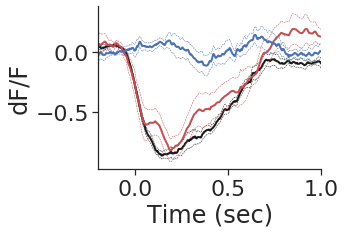

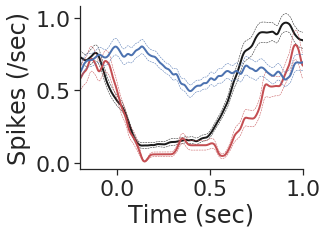

In [25]:
# valid_cell = np.ones(sub_ave.shape[0]).astype('bool')
c_list = ['k', 'r', 'b']
labels = ['CL', 'Swim-only', 'Visual-only']

plt.figure(figsize=(4, 3))
for n in range(3):
    ave_ = sub_ave[:, n, :]/np.abs(min_sub[:, np.newaxis])
    std_ = sem(ave_[valid_cell], axis=0, nan_policy='omit')
    valid_cell_ = ave_[valid_cell].std()
    mean_ = np.mean(ave_[valid_cell], axis=0)
    plt.plot(t_label, mean_, f'-{c_list[n]}', lw=2)
    plt.plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
    plt.plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
    plt.xlim([-0.2, 1])
    plt.xlabel('Time (sec)')
    plt.ylabel('dF/F')
    sns.despine()
# plt.savefig('../Plots/sovo/pop_ave_sub.pdf')

plt.figure(figsize=(4, 3))
for n in range(3):
    ave_ = spk_ave[:, n, :]
    mean_ = np.mean(ave_[valid_cell], axis=0)
    std_ = sem(ave_[valid_cell], axis=0, nan_policy='omit')/2
    plt.plot(t_label, mean_, f'-{c_list[n]}', lw=2)
    plt.plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
    plt.plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
    plt.xlim([-0.2, 1])
    plt.xlabel('Time (sec)')
    plt.ylabel('Spikes (/sec)')
    sns.despine()
# plt.savefig('../Plots/sovo/pop_ave_spk.pdf')

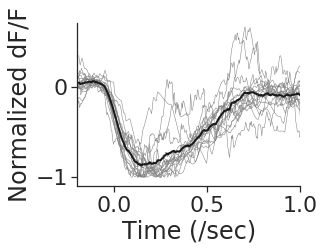

In [26]:
ave_ = sub_ave[:, 0, :]/np.abs(min_sub[:, np.newaxis])
plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_[valid_cell].T, '-', lw=0.5, color='gray')
plt.plot(t_label, np.mean(ave_[valid_cell], axis=0), '-k', lw=2)
plt.xlim([-0.2, 1.0])
plt.ylim([-1.1, 0.7])
plt.ylabel('Normalized dF/F')
plt.xlabel('Time (/sec)')
sns.despine()
# plt.savefig('../Plots/sovo/example_sub.pdf')

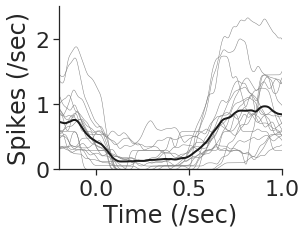

In [27]:
ave_ = spk_ave[:, 0, :]
plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_[valid_cell].T, '-', lw=0.5, color='gray')
plt.plot(t_label, np.mean(ave_[valid_cell], axis=0), '-k', lw=2)
plt.xlim([-0.2, 1.0])
plt.ylim([0, 2.5])
plt.ylabel('Spikes (/sec)')
plt.xlabel('Time (/sec)')
sns.despine()
# plt.savefig('../Plots/sovo/example_spk.pdf')